In [1]:
import requests
import re
import io
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime
from PyPDF2 import PdfFileReader
import logging
import sys
import pandas as pd


logger = logging.getLogger() 
logger.handlers = [logging.StreamHandler()]
logger.setLevel(logging.INFO)


In [2]:
csv_file = 'data/who-global-cases.csv'
png_file = 'images/who-global-cases.png'

In [3]:
# display the last execute time
datetime.now()

datetime.datetime(2020, 2, 6, 8, 45, 16, 979404)

### Scraping

In [4]:
def analyze_report(url):
    '''
    Analyze a situation report url
    '''
    response = requests.get(url)
    f_obj = io.BytesIO(response.content)
    pdf = PdfFileReader(f_obj)
    page_zero = pdf.getPage(0)
    
    text  = page_zero.extractText()
    
    try:
        # use regular expression to extract date
        p_date = re.compile("Data as reported by ([a-zA-Z0-9\n\s]+).*\*", re.DOTALL)
        m_date = p_date.search(text)
        report_date_str = m_date.group(1).replace("\n","")
        report_date = datetime.strptime(report_date_str, '%d %B %Y').strftime('%Y-%m-%d')

        # use regular expression to extract global cases
        p_global = re.compile("Globally ([\s\n0-9]+)", re.DOTALL)
        m_global = p_global.search(text)
        global_cases_str = m_global.group(1).replace("\n","").strip()
        global_cases = int(global_cases_str)

        return {"date":report_date, "global_cases": global_cases, "report_url": url}
    except AttributeError as e:
        logger.warning(f'Unable to extract from "{url}" : {e}\nSkip processing.')
        return None


In [5]:
def get_reports_urls(home_url):
    '''
    Extract situation reports URL from WHO's page
    '''
    # unable to analyse these reports
    skipped_urls = [
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200126-sitrep-6-2019--ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200125-sitrep-5-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200124-sitrep-4-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200123-sitrep-3-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200122-sitrep-2-2019-ncov.pdf',
        'https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200121-sitrep-1-2019-ncov.pdf'
    ]  
    
    urls = []
    response = requests.get(home_url)
    soup = BeautifulSoup(response.content, 'lxml')
    tags = soup.find_all('a')
    for tag in tags:
        if len(tag.contents)>0:
            content = str(tag.contents[0])
            if "Situation report - " in content:
                url = urljoin(home_url ,  tag.get('href')).split('?')[0]
                
                if url not in skipped_urls:
                    urls.append(url)

    return urls


In [6]:
def get_WHO_stats():
    reports_home_url = 'https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/'
    reports_urls = get_reports_urls(reports_home_url)
    df = pd.read_csv(csv_file)
    for url in reports_urls:
        if df['report_url'].str.contains(url).any():
            print('already processed ', url, ' in previous runs')
            continue
        stats = analyze_report(url)
        df = df.append(stats, ignore_index = True)
    return df

In [7]:
df = get_WHO_stats()

already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200205-sitrep-16-ncov.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200204-sitrep-15-ncov.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200203-sitrep-14-ncov.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200202-sitrep-13-ncov-v3.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200201-sitrep-12-ncov.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200131-sitrep-11-ncov.pdf  in previous runs
already processed  https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200130-sitrep-10-ncov.pdf  in previous runs
already processed  https://www.who.int/docs/d

In [8]:
df

,date,global_cases,report_url
0,2020-01-27,2798,https://www.who.int/docs/default-source/corona...
1,2020-01-28,4593,https://www.who.int/docs/default-source/corona...
2,2020-01-29,6065,https://www.who.int/docs/default-source/corona...
3,2020-01-30,7818,https://www.who.int/docs/default-source/corona...
4,2020-01-31,9826,https://www.who.int/docs/default-source/corona...
5,2020-02-01,11953,https://www.who.int/docs/default-source/corona...
6,2020-02-02,14557,https://www.who.int/docs/default-source/corona...
7,2020-02-03,17391,https://www.who.int/docs/default-source/corona...
8,2020-02-04,20630,https://www.who.int/docs/default-source/corona...
9,2020-02-05,24554,https://www.who.int/docs/default-source/corona...


### Plot graph and save to files

In [9]:
import seaborn as sns
from pathlib import Path

In [10]:
df.sort_values(by=['date'], inplace=True)

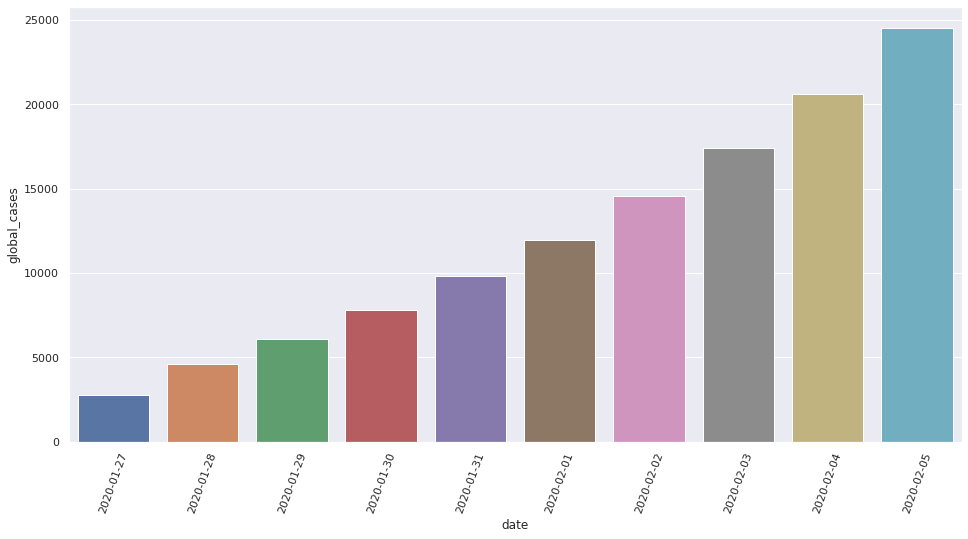

In [14]:
sns.set(rc={'figure.figsize':(16,8.5)})

bar_chart = sns.barplot(x='date', y='global_cases', data=df)
bar_chart.tick_params(axis='x', labelrotation=70)


In [15]:
bar_chart_fig = bar_chart.get_figure()


In [16]:
df.to_csv(csv_file, index=False)
bar_chart_fig.savefig(png_file)
